# SELVE Framework Validation – Big Five Correlation Analysis

**Goal:**  
Validate that our proposed 8 SELVE dimensions align with empirical Big Five data.

---

## SELVE Dimensions

| Name       | Dimension           | Symbol | Tagline               | Pronunciation | Element / Vibe          |
|-----------|--------------------|--------|----------------------|---------------|------------------------|
| LUMEN     | Social Energy       | ✨     | The Radiant          | LOO-men       | Light / Fire           |
| AETHER    | Emotional Stability | 🌫️     | The Transcendent     | EE-ther       | Air / Spirit           |
| ORPHEUS   | Empathy             | 🎵     | The Harmonizer       | OR-fee-us     | Sound / Vibration      |
| VARA      | Honesty             | ⚖️     | The Truthkeeper      | VAR-ah        | Earth / Foundation     |
| CHRONOS   | Patience            | ⏳     | The Timeless         | KROH-nos      | Time                   |
| KAEL      | Assertiveness       | 🔥     | The Catalyst         | KAYL          | Fire / Force           |
| ORIN      | Organization        | 🧭     | The Architect        | OR-in         | Earth / Structure      |
| LYRA      | Openness            | 🦋     | The Explorer         | LIE-rah       | Air / Change           |

---


## Setup: Check Data Availability

First, let's check if the data exists on this server.

In [5]:
# Check local environment and data path
import os
from pathlib import Path

print('System info:')
print('  User:', os.environ.get('USER'))
print('  Home :', Path.home())
print('  CWD  :', Path.cwd())

data_path = Path('/home/chris/selve/data/openpsychometrics-rawdata/IPIP-FFM-data-8Nov2018/data-final.csv')
print('\nExpected data path:', data_path)
if not data_path.exists():
    raise FileNotFoundError(f'Big Five dataset not found at {data_path} - please ensure the file exists locally')

print('✅ Data file found locally:', data_path)
print('   Size: {:.1f} MB'.format(data_path.stat().st_size / (1024*1024)))

System info:
  User: christopher
  Home : /home/chris
  CWD  : /home/chris/selve/notebooks

Expected data path: /home/chris/selve/data/openpsychometrics-rawdata/IPIP-FFM-data-8Nov2018/data-final.csv
✅ Data file found locally: /home/chris/selve/data/openpsychometrics-rawdata/IPIP-FFM-data-8Nov2018/data-final.csv
   Size: 397.0 MB


## Install required packages


In [7]:
!pip install pandas numpy scikit-learn factor-analyzer matplotlib seaborn scipy


  Using cached pandas-2.3.3-cp312-cp312-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (91 kB)
  Using cached numpy-2.3.4-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)
  Using cached numpy-2.3.4-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)
  Installing build dependencies ...   Installing build dependencies ... -done
  Getting requirements to build wheel ... one
  Getting requirements to build wheel ... -done
  Preparing metadata (pyproject.toml) ... one
  Preparing metadata (pyproject.toml) ... -done
one
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached contourpy-1.3.3-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (5.5 kB)
  Using cached contourpy-1.3.3-cp312-cp3

In [8]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100
print('✅ Imports ready')

✅ Imports ready


## Load Big Five data (local)

In [10]:
print('Loading data...')
df_big5 = pd.read_csv(data_path, sep='\t')  # Use '\t' for tab-separated data
print(f'✅ Loaded {len(df_big5):,} responses')
print(f'Columns: {df_big5.shape[1]}')
print('First columns:', list(df_big5.columns[:10]))


Loading data...
✅ Loaded 1,015,341 responses
Columns: 110
First columns: ['EXT1', 'EXT2', 'EXT3', 'EXT4', 'EXT5', 'EXT6', 'EXT7', 'EXT8', 'EXT9', 'EXT10']


## Define Big Five item structure

In [11]:
big5_dimensions = {
    'EXT': [f'EXT{i}' for i in range(1, 11)],
    'EST': [f'EST{i}' for i in range(1, 11)],
    'AGR': [f'AGR{i}' for i in range(1, 11)],
    'CSN': [f'CSN{i}' for i in range(1, 11)],
    'OPN': [f'OPN{i}' for i in range(1, 11)],
}
all_items = [item for items in big5_dimensions.values() for item in items]
missing = [item for item in all_items if item not in df_big5.columns]
if missing:
    print('⚠️ Missing items:', missing)
else:
    print('✅ All 50 Big Five items found')

✅ All 50 Big Five items found


In [ ]:
# Clean and sample for faster analysis
df_clean = df_big5[all_items].copy()
df_clean = df_clean.dropna()
invalid_mask = ((df_clean < 1) | (df_clean > 5)).any(axis=1)
df_clean = df_clean[~invalid_mask]
if len(df_clean) > 50000:
    df_analysis = df_clean.sample(n=50000, random_state=42)
else:
    df_analysis = df_clean
print('Data prepared for analysis:', df_analysis.shape)
print()

# Reverse-score negatively worded items (5→1, 4→2, 3→3, 2→4, 1→5)
reverse_items = {
    'EXT': ['EXT2', 'EXT4', 'EXT6', 'EXT8', 'EXT10'],
    'EST': ['EST1', 'EST3', 'EST5', 'EST6', 'EST7', 'EST8', 'EST9', 'EST10'],
    'AGR': ['AGR1', 'AGR3', 'AGR5', 'AGR7'],
    'CSN': ['CSN2', 'CSN4', 'CSN6', 'CSN8'],
    'OPN': ['OPN2', 'OPN4', 'OPN6']
}

all_reverse = [item for items in reverse_items.values() for item in items]
print(f'Reverse-scoring {len(all_reverse)} negatively worded items...')
for item in all_reverse:
    df_analysis[item] = 6 - df_analysis[item]
print('✅ Reverse scoring complete')

Data prepared for analysis: (50000, 50)


In [13]:
# Cronbach's alpha function
def cronbach_alpha(df, items):
    item_data = df[items].dropna()
    k = len(items)
    item_vars = item_data.var(axis=0, ddof=1)
    total_var = item_data.sum(axis=1).var(ddof=1)
    return (k / (k - 1)) * (1 - item_vars.sum() / total_var)

alpha_results = {}
selve_map = {'EXT':'LUMEN ✨','EST':'EIRENE 🌿','AGR':'AMARA/SERA 💫🍃','CSN':'ORIN 🧭','OPN':'LYRA 🦋'}
for dim, items in big5_dimensions.items():
    alpha = cronbach_alpha(df_analysis, items)
    alpha_results[dim] = alpha
    status = '✅' if alpha >= 0.8 else ('⚠️' if alpha >= 0.7 else '❌')
    print(f"{status} {dim} → {selve_map[dim]:15s}: α = {alpha:.3f}")

❌ EXT → LUMEN ✨        : α = -0.438
❌ EST → EIRENE 🌿       : α = 0.691
❌ AGR → AMARA/SERA 💫🍃  : α = -0.072
❌ CSN → ORIN 🧭         : α = 0.009
❌ OPN → LYRA 🦋         : α = 0.235


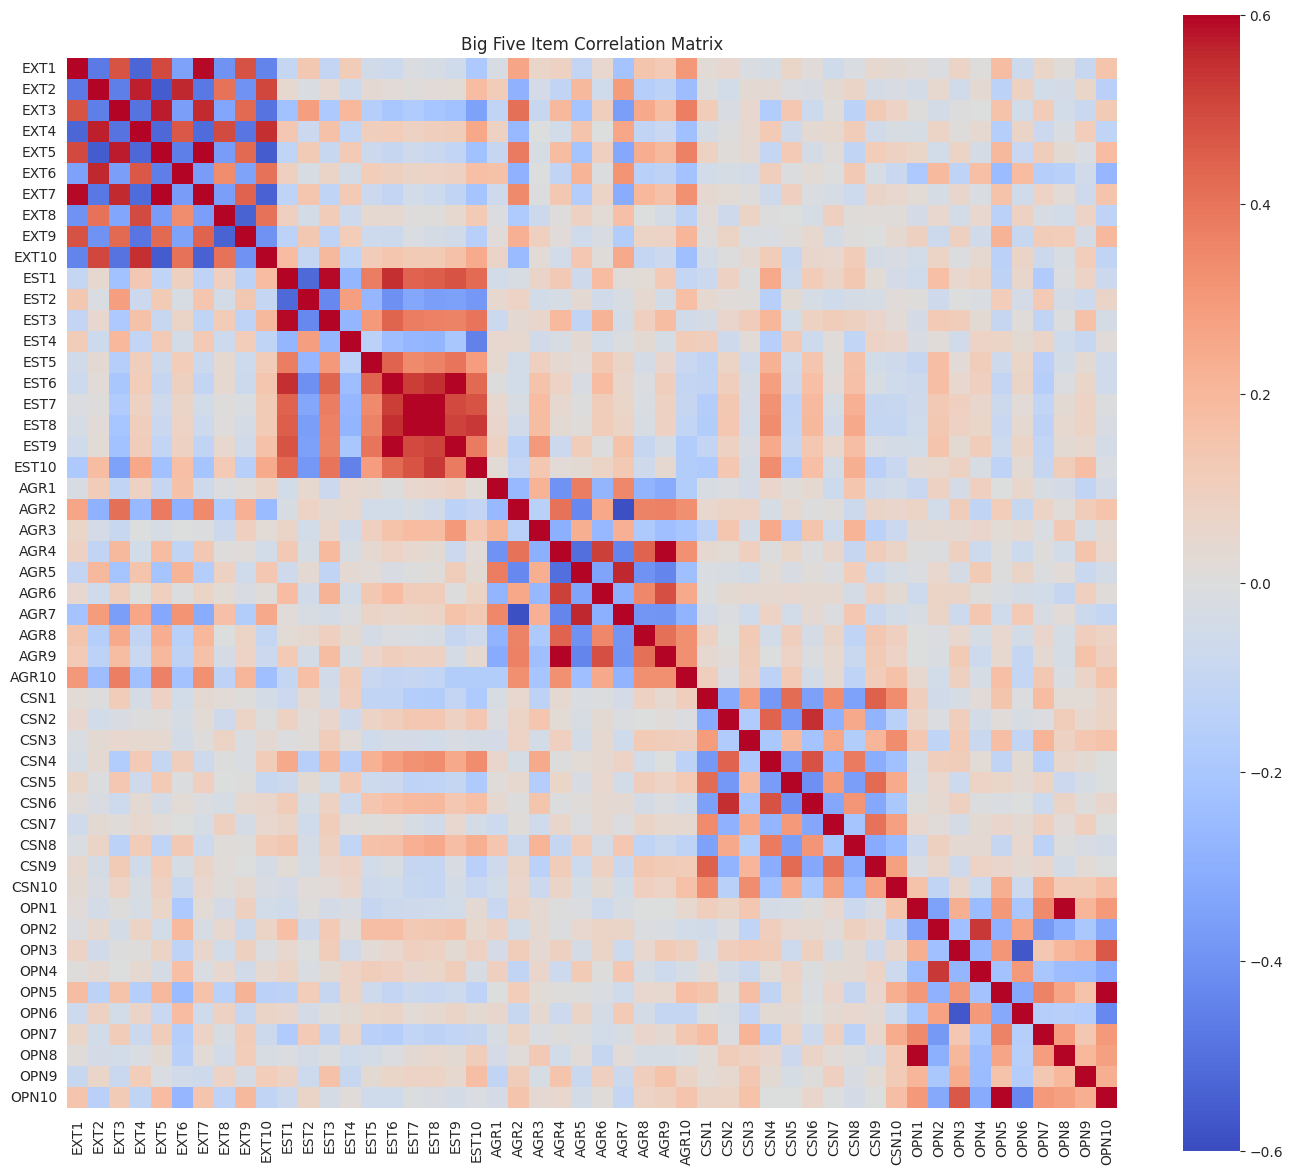

In [14]:
# Correlation matrix and heatmap
corr_matrix = df_analysis[all_items].corr()
plt.figure(figsize=(14,12))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, vmin=-0.6, vmax=0.6, square=True)
plt.title('Big Five Item Correlation Matrix')
plt.tight_layout()
plt.show()

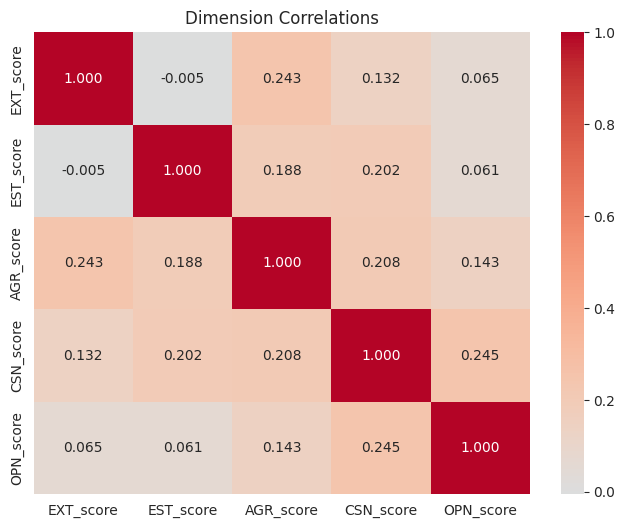

In [15]:
# Dimension scores and inter-dimension correlations
for dim, items in big5_dimensions.items():
    df_analysis[f'{dim}_score'] = df_analysis[items].mean(axis=1)
score_cols = [f'{d}_score' for d in big5_dimensions.keys()]
dim_corr = df_analysis[score_cols].corr()
plt.figure(figsize=(8,6))
sns.heatmap(dim_corr, annot=True, fmt='.3f', cmap='coolwarm', center=0)
plt.title('Dimension Correlations')
plt.show()

## Run locally

From a terminal on your LOCAL machine run:

```bash
cd /home/chris/selve
jupyter lab
```

Then open `notebooks/01_big5_validation.ipynb` and choose Kernel → Restart & Run All.